In [1]:

import numpy as np
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys
import pathlib
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('Could not find a GPU. Defaulting to CPU instead.')
else:
    print('Using GPU:', torch.cuda.get_device_name(0))
## set the core folder
ks_dir = r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4"

## Behavioral analysis
DLC = pd.read_hdf(r"Z:\Koji\DLC\9153\9153_Day5_4rewards2025-01-29DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210_filtered.h5")
snout_x = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Snout', 'x'))].values
snout_y = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Snout', 'y'))].values
tail_x = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Tail', 'x'))].values
tail_y = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Tail', 'y'))].values

avg_x = (snout_x + tail_x) / 2  # Average position
avg_y = (snout_y + tail_y) / 2  # Average position
dx = np.diff(avg_x)
dy = np.diff(avg_y)
speed = np.sqrt(dx**2 + dy**2)        # speed calculation
speed = np.concatenate([[0], speed])  # Pad with zero to match original length

## load the files
celltype = pd.read_csv(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\unit_classification_rulebased.csv")
tagged_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_units_final.npy")
spike_clusters = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_clusters.npy")
spike_seconds = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_seconds_adj.npy")
spike_positions = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_positions.npy")
strobe_seconds = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\strobe_seconds.npy")
tagged_good_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_good_units.npy")
tagged_mua_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_mua_units.npy")
print("tagged_unit (original)        =", len(tagged_good_unit)+len(tagged_mua_unit))

start = strobe_seconds[0]
end = strobe_seconds[-1]

# Create a mask based on the original spike_seconds
mask = (spike_seconds >= start) & (spike_seconds <= end)
spike_seconds = spike_seconds[mask]
spike_clusters = spike_clusters[mask]
spike_positions = spike_positions[mask]

# Select MSN units
non_tagged_msn = celltype.loc[celltype['cell_type'] == 'MSN', 'unit_id'].values
non_tagged_msn = non_tagged_msn[~np.isin(non_tagged_msn, tagged_unit)]

print("tagged_unit (waveform filter) =", len(tagged_unit), ", non_tagged_msn             =", len(non_tagged_msn))

Using GPU: NVIDIA GeForce RTX 3070


FileNotFoundError: File Z:\Koji\DLC\9153\9153_Day5_4rewards2025-01-29DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210_filtered.h5 does not exist

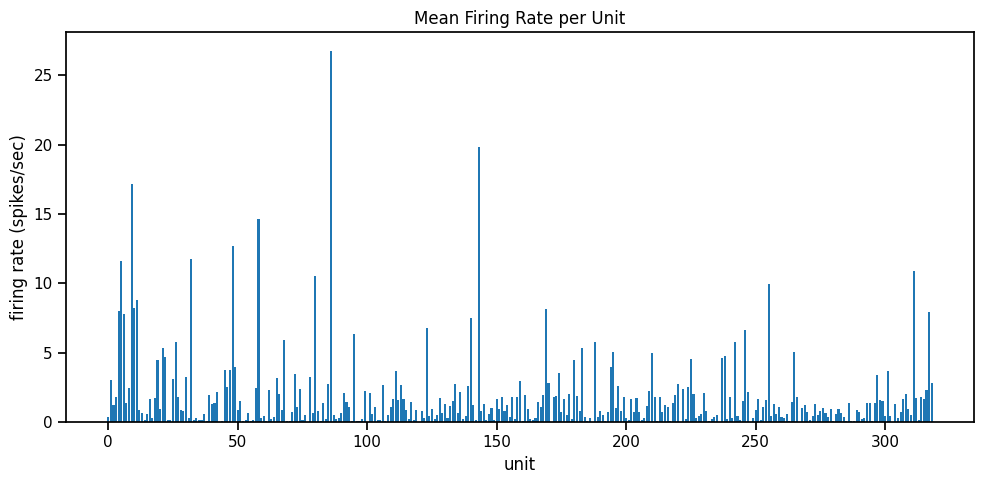

In [2]:
from ppseq.model import PPSeq
from ppseq.plotting import plot_model

# Combine tagged_unit and non_tagged_msn
selected_units = np.concatenate([tagged_unit, non_tagged_msn])
selected_units = np.unique(selected_units)  # remove duplicates, if any

# Mask spikes to keep only those from selected units
unit_mask = np.isin(spike_clusters, selected_units)
spike_seconds_sel = spike_seconds[unit_mask]
spike_clusters_sel = spike_clusters[unit_mask]

# Remap selected unit IDs to a contiguous range starting from 0
#   e.g. If selected_units = [3, 5, 8], then all spikes of unit 3 -> 0, 5 -> 1, 8 -> 2
unit_id_map = {unit: i for i, unit in enumerate(selected_units)}
spike_clusters_remapped = np.array([unit_id_map[u] for u in spike_clusters_sel])
n_selected_units = len(selected_units)

# Create spike count data for each unit
bin_size_ms = 5
bin_size = bin_size_ms / 1000.0  # Convert ms to seconds
n_bins = int(np.ceil((end - start) / bin_size))

spike_counts = np.zeros((n_selected_units, n_bins), dtype=np.float32)
for i, unit in enumerate(selected_units):
    unit_spikes = spike_seconds_sel[spike_clusters_remapped == i]
    spike_counts[i], _ = np.histogram(unit_spikes, bins=n_bins, range=(start, end))

mean_firing_rate = np.mean(spike_counts, axis=1) / bin_size  # spikes/sec

plt.figure(figsize=(10, 5))
plt.bar(np.arange(n_selected_units), mean_firing_rate)
plt.xlabel("unit")
plt.ylabel("firing rate (spikes/sec)")
plt.title("Mean Firing Rate per Unit")
plt.tight_layout()
plt.show()

In [7]:
spike_counts_torch = torch.tensor(spike_counts, dtype=torch.float32).to(device)

# parameters
num_templates = 6
template_duration = 1000 // bin_size_ms  # (ms in bins)

# Set gamma priors for the amplitudes
# The amplitudes are the expected number of spikes per sequence event
alpha_a0 = 2.0              
beta_a0 = alpha_a0 / 30.   

# The background rates are the expected number of spikes per bin,
# absent any sequence events
alpha_b0 = 1.0              
beta_b0 = alpha_b0 / 0.005

# Initialize the model
model = PPSeq(
    num_templates=num_templates,
    num_neurons=n_selected_units,
    template_duration=template_duration,
    alpha_a0=alpha_a0,                  
    beta_a0=beta_a0,                    
    alpha_b0=alpha_b0,                  
    beta_b0=beta_b0,
    device=device                    
)

# Initialize to a reasonable guess of the background rates
model.base_rates = torch.tensor(spike_counts.mean(axis=1), device=device)

# Initialize to a reasonable guess of a single template
model.template_scales[0] = torch.ones(n_selected_units, device=device) / n_selected_units
model.template_offsets[0] = dist.Uniform(0, template_duration).sample((n_selected_units,)).to(device)
model.template_widths[0] = (50 / bin_size_ms) * torch.ones(n_selected_units, device=device)


lps, amplitudes = model.fit(spike_counts_torch,
                            num_iter=50,
                            initialization='none')

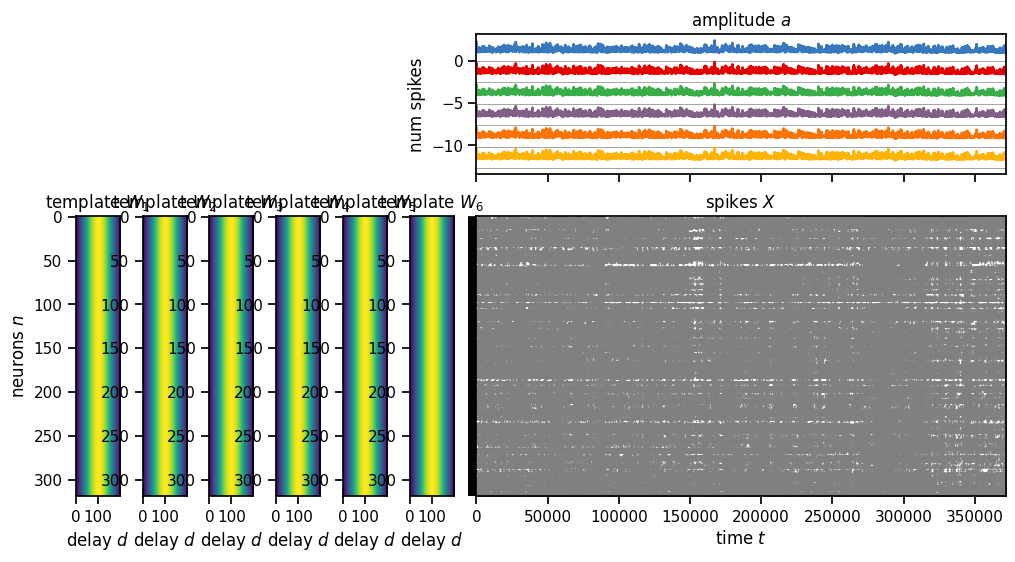

In [8]:
plot_model(model.templates, amplitudes, spike_counts_torch)